In [ ]:
import tensorflow as tf
tf.__version__

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from pathlib import Path
from types import NoneType

from IPython import display


In [ ]:
# Load data.  The way I did this is stupid but it's late and I'm tired.
train_images = None
for filename in glob.glob('dataset/DELAUNAY_train/*/*.png'):
    im = PIL.Image.open(filename)
    # im = PIL.ImageOps.grayscale(im)
    if isinstance(train_images, NoneType):
        train_images = np.expand_dims(np.array(im.resize((64,64))), axis=0)
    else:
        im_arr = np.expand_dims(np.array(im.resize((64,64))), axis=0)
        train_images = np.append(train_images, im_arr, axis=0)

# test_images = None
# for filename in glob.glob('dataset/DELAUNAY_test/*/*.png'):
#     im = PIL.Image.open(filename)
#     im = PIL.ImageOps.grayscale(im)
#     if isinstance(test_images, NoneType):
#         test_images = np.expand_dims(np.array(im.resize((64,64))), axis=0)
#     else:
#         im_arr = np.expand_dims(np.array(im.resize((64,64))), axis=0)
#         test_images = np.append(test_images, im_arr, axis=0)


In [9]:
train_images = train_images.astype('float32')
train_images = train_images.reshape(train_images.shape[0], 64, 64, 3).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [11]:
BUFFER_SIZE = 9202  # Size of training dataset
BATCH_SIZE = 256

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

2022-07-22 14:54:37.542942: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(16*16*256, use_bias = False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((16,16,256)))
    assert model.output_shape == (None, 16, 16, 256)

    model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias = False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias = False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias = False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)

    return model

In [14]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
# generated_image *= 127.5
# generated_image += 127.5
# gen_arr = generated_image.numpy()[0,:,:,:]
# gen_image = PIL.Image.fromarray(np.uint8(gen_arr))

# plt.imshow(gen_image)

In [15]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


In [16]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00167484]], shape=(1, 1), dtype=float32)


In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [18]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [19]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [20]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [21]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [22]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])


In [23]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [24]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      # plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.imshow(PIL.Image.fromarray(np.uint8((predictions*127.5+127.5).numpy()[i,:,:,:])))
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch), transparent = False, facecolor='white')
  plt.show()

In [25]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

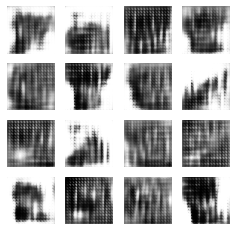

In [26]:
train(train_dataset, EPOCHS)

In [27]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


In [28]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))


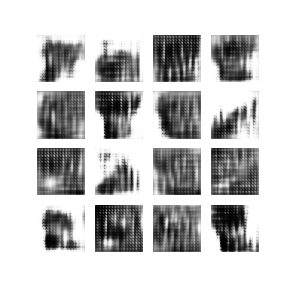

In [29]:
display_image(EPOCHS)


In [30]:
anim_file = 'wiki-art-gan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


/var/folders/2y/fjhpp5yn6yg052gdpg7t7bth0000gq/T/ipykernel_20713/528534172.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/var/folders/2y/fjhpp5yn6yg052gdpg7t7bth0000gq/T/ipykernel_20713/528534172.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
